# Os dados

Para coletar os dados de outros países, foram utilizadas as APIs dos sites:

- [About Corona](https://about-corona.net/dashboard/)
- [Europe RestFul](https://restcountries.eu/)

In [1]:

import requests
import pandas as pd

covid_api = 'https://corona-api.com/countries/'
rest_countries = 'https://restcountries.eu/rest/v2/alpha/'
country = 'IT' # Alpha-2 ISO3166

data_json =  requests.get(covid_api + country).json()
country = requests.get(covid_api + country).json()

N = country['data']['population']

print(country['data']['name'])


Italy


### Organizando os dados

In [2]:

from datetime import datetime

df = pd.DataFrame(data_json['data']['timeline'])
df = df.sort_values('date').reset_index()

from datetime import datetime, timedelta
df['date'] = [datetime.fromisoformat(f) for f in df['date']]
df = df.drop_duplicates(subset='date', keep = 'last')

# Criando o vetor de tempo
first_date = df['date'].iloc[0]
size_days = (df['date'].iloc[-1] - df['date'].iloc[0]).days
date_vec = [first_date + timedelta(days=k) for k in range(size_days)]

new_df = pd.DataFrame(date_vec, columns=['date'])
new_df = pd.merge(new_df, df, how='left', on= 'date')
new_df = new_df.drop(columns= ['index',  'updated_at', 'is_in_progress'])

for col in new_df.columns[1:]:
    new_df[col] = new_df[col].interpolate(method='polynomial', order=1)
df = new_df.dropna()

df.head()


,date,deaths,confirmed,active,recovered,new_confirmed,new_recovered,new_deaths
0,2020-01-30,0.0,2.000000,2.000000,0.0,2.000000,0.0,0.0
1,2020-01-31,0.0,2.000000,2.000000,0.0,0.000000,0.0,0.0
2,2020-02-01,0.0,2.142857,2.142857,0.0,0.142857,0.0,0.0
3,2020-02-02,0.0,2.285714,2.285714,0.0,0.285714,0.0,0.0
4,2020-02-03,0.0,2.428571,2.428571,0.0,0.428571,0.0,0.0


### Visualizando os dados

In [3]:

from bokeh.models   import Legend, ColumnDataSource, RangeTool, LinearAxis, Range1d, HoverTool
from bokeh.palettes import brewer, Inferno256
from bokeh.plotting import figure, show
from bokeh.layouts  import column
from bokeh.io       import output_notebook

output_notebook()

import numpy as np

# Criando os valores para legenda no plot
year =  [str(int(d.year)) for d in df['date'] ]
month = [("0"+str(int(d.month)))[-2:] for d in df['date'] ]
day =   [("0"+str(int(d.day)))[-2:] for d in df['date'] ]

# Criando a fonte de dados
source = ColumnDataSource(data={
    'Data'       : df['date'].values,
    'd': day, 'm': month, 'y': year,
    'Infectados Acc' : df['confirmed'].values,
    'Mortes'     : df['deaths'].values,
    'Ativo'     : df['active'].values,
    'Recuperados': df['recovered'].values
})


# Criando a figura
p = figure(plot_height=500,
           plot_width=600,
           x_axis_type="datetime", 
           tools="", 
           #y_axis_type="log",
           toolbar_location=None,
           title="Evolução do COVID - " + country['data']['name'])

# Preparando o estilo
p.grid.grid_line_alpha = 0
p.ygrid.band_fill_color = "olive"
p.ygrid.band_fill_alpha = 0.1
p.yaxis.axis_label = "Indivíduos"
p.xaxis.axis_label = "Dias"

# Incluindo as curvas
i_p = p.line(x='Data', y='Ativo',
             legend_label="Infectados", 
             line_cap="round", line_width=5, color="#c62828", source=source)
m_p = p.line(x='Data', y='Mortes',
             legend_label="Mortes",
             line_cap="round", line_width=5, color="#512da8", source=source)
c_p = p.line(x='Data', y='Infectados Acc',
             legend_label="Infectados Acc",
             line_cap="round", line_width=5, color="#0288d1", source=source)
r_p = p.line(x='Data', y='Recuperados',
             legend_label="Recuperados",
             line_cap="round", line_width=5, color="#388e3c", source=source)

# Colocando as legendas
p.legend.click_policy="hide"
# p.legend.location = "top_left"
p.legend.location = "top_left"

# Incluindo a ferramenta de hover
p.add_tools(HoverTool(
    tooltips=[
        ( 'Indivíduos', '$y{i}'),
        ( 'Data',       '@d/@m/@y' ),
    ],
    renderers=[
        m_p, i_p, c_p, r_p
    ]
))

show(p)


Loading BokehJS ...

## Verificando os dados

In [4]:

dif_I = np.diff(df['active'])
cum = []
cum.append(dif_I[0])

for k, i in enumerate(dif_I):
    cum.append(cum[-1] + i)
    
cum = np.array(cum)
cum += df['deaths'].to_numpy() + df['recovered'].to_numpy()

print("Erro entre casos acumulados e valores de confirmados: {}".format(
        round(sum((cum - df['confirmed'].values)**2 / len(cum)),2) ) ) 


Erro entre casos acumulados e valores de confirmados: 4.0


## Criando os dados SIR

In [5]:

I = df['active'].to_numpy()
R = df['recovered'].to_numpy()
M = df['deaths'].to_numpy()
S = N - R - I

# Creating the time vector
t = np.linspace(0, len(I), len(I))


Sd, Id, Md, Rd, td = S, I, M, R, t


# Estimando utilizando todos os dados

In [6]:

from models import *

dataset = dict(S=Sd, I=Id, R=Rd)

# Create the model
sir_model = ss.SIR(pop=N, focus=["S", "I", "R"])

# Adjust the parameters
sir_model.fit(dataset, td,
              search_pop=True,
              pop_sens=[0.001,0.01],
              beta_sens=[100000,100], 
              r_sens=[100000,100])

# Predict the model
sim_res = sir_model.predict((Sd[0],Id[0], Rd[0]), td)


Loading BokehJS ...

	 ├─ S(0) ─ I(0) ─ R(0) ─  [60340326.0, 2.0, 0.0]
	 ├─ beta ─   1   r ─   0.14285714285714285
	 ├─ beta bound ─   1e-05  ─  100
	 ├─ r bound ─   1.4285714285714284e-06  ─  14.285714285714285
	 ├─ equation weights ─   [0.0017941069791369705, 1, 0.6955915519202226]
	 ├─ Running on ─  differential_evolution SciPy Search Algorithm
	 └─ Defined at:  67.32443112140778  ─  0.02248540764438355 



In [47]:

print("Parâmetros estimados: ", sir_model.parameters)
print("Suposto Ro: ", sir_model.parameters[0] * sir_model.parameters[-1] / sir_model.parameters[1])
print("Dias contaminados: ", 1 / sir_model.parameters[1])


Parâmetros estimados:  [6.75394656e+01 2.23313371e-02 3.03594922e-03]
Suposto Ro:  9.182002250132081
Dias contaminados:  44.780121919213144


In [8]:

p = figure(plot_height=500,
           plot_width=600, 
           tools="", 
           toolbar_location=None,
           title="Evolução do COVID - " + country['data']['name'])

# Preparando o estilo
p.grid.grid_line_alpha = 0
p.ygrid.band_fill_color = "olive"
p.ygrid.band_fill_alpha = 0.1
p.yaxis.axis_label = "Indivíduos"
p.xaxis.axis_label = "Dias"

p.line(t, I,  
       legend_label="Infectados", color="#c2185b", line_width=4)
p.line(t, R,  
       legend_label="Removidos", color="#0288d1", line_width=4)

# Show the results
p.line(td, sim_res[1],  
       legend_label="Infectados - Modelo", line_dash="dashed", color="#5e35b1", line_width=3)
p.line(td, sim_res[2],  
    legend_label="Removidos - Modelo", line_dash="dashed", color="#f57f17", line_width=3)
p.line(td, sim_res[0],  
      legend_label="Susceptible - Modelo", line_dash="dashed", color="#43a047", line_width=3)

show(p)


# Monte Carlo


Nesta parte, faremos um teste aumentando a quantidade de amostras de treinamento e prevendo o momento do pico da epidemia a medida que mais dias são utilizados para treinamento. Esse estudo vai possibilitar a análise da certeza da previsão do pico da epidemia antes desse acontecer.

In [9]:

saved_param = {'r':[], 'beta':[], 'pop':[]}
saved_prediction = []

pred_t = np.array(range(int(td[-1]) + 120))

for i in range(35,len(I),1):

    dataset = dict(S=Sd[:i], I=Id[:i], R=Rd[:i])
    td_ = td[:i]

    # Create the model
    sir_model = ss.SIR(pop=N, focus=["S", "I", "R"], verbose = False)

    # Adjust the parameters
    sir_model.fit(dataset, td_,
                  search_pop=True,
                  pop_sens=[0.001,0.01],
                  beta_sens=[100000,100], 
                  r_sens=[100000,100])
    
    saved_param['r'].append(sir_model.parameters[0])
    saved_param['beta'].append(sir_model.parameters[1])
    saved_param['pop'].append(sir_model.parameters[2])
    
    saved_prediction.append(sir_model.predict((Sd[0],Id[0],Rd[0]), pred_t))
    

# Visualizando as previsões

Vamos analisar as previsões quando somente os dados antes do pico são fornecidos ao modelo, e as previões utilizando os dados após o pico:

In [10]:

p2 = figure(plot_height=500,
           plot_width=600, 
           tools="", 
           toolbar_location=None,
           title="Evolução do COVID - " + country['data']['name'])

# Preparando o estilo
p2.grid.grid_line_alpha = 0
p2.ygrid.band_fill_color = "olive"
p2.ygrid.band_fill_alpha = 0.1
p2.yaxis.axis_label = "Indivíduos"
p2.xaxis.axis_label = "Dias"

# Incluindo as curvas
p2.line(td, Id,
       legend_label="Infectados", 
       line_cap="round", line_width=3, color="#c62828")

for data in saved_prediction[45:]:
    p2.line(pred_t[:len(td)], -data[1][:len(td)],
           legend_label="Previsão Infectados - Depois do pico", 
           line_cap="round", line_width=4, color="#ffa000", line_alpha = 0.1)

for data in saved_prediction[:45]:
    p2.line(pred_t[:len(td)], -data[1][:len(td)],
           legend_label="Previsão Infectados - Antes do pico", 
           line_cap="round", line_dash="dashed", line_width=4, color="#42a5f5", line_alpha = 0.1)

# Colocando as legendas
p2.legend.click_policy="hide"
p2.legend.location = "bottom_left"

show(p2)


# Visualizando os ajustes dos grupos

Aqui vamos analisar as previsões obtidas para cada grupo $S(t)$, $I(t)$ e $R(t)$, a medida que mais dias foram informados ao modelo.

In [11]:

p3 = figure(plot_height=500,
           plot_width=600, 
           tools="", 
           toolbar_location=None,
           title="Evolução do COVID - " + country['data']['name'])

plot_all = True

# Preparando o estilo
p3.grid.grid_line_alpha = 0
p3.ygrid.band_fill_color = "olive"
p3.ygrid.band_fill_alpha = 0.1
p3.yaxis.axis_label = "Indivíduos"
p3.xaxis.axis_label = "Dias"

# Incluindo as curvas
for data in saved_prediction[10:45]:
    p3.line(pred_t, data[1],
           legend_label="Previsão Infectados", 
           line_cap="round", line_width=4, color="#42a5f5", line_alpha = 0.1)

    p3.line(pred_t, data[0],
       legend_label="Previsão Suscetiveis", 
       line_cap="round", line_width=4, color="#ff5722", line_alpha = 0.07)
    
    p3.line(pred_t, data[2],
       legend_label="Previsão Recuperados", 
       line_cap="round", line_width=4, color="#9c27b0", line_alpha = 0.07)
    
    
p3.line(td, Id,
       legend_label="Infectados", 
       line_cap="round", line_width=3, color="#005cb2", line_dash = 'dashed')

if plot_all:
    p3.line(td, Rd,
           legend_label="Recuperados", 
           line_cap="round", line_width=3, color="#5e35b1", line_dash = 'dashed')

    p3.line(td, N*saved_param['pop'][-10] - Rd - Id,
           legend_label="Suscetiveis", 
           line_cap="round", line_width=3, color="#b71c1c", line_dash = 'dashed')

# Colocando as legendas
p3.legend.click_policy="hide"
p3.legend.location = "top_right"

show(p3)


# Análise de confiança

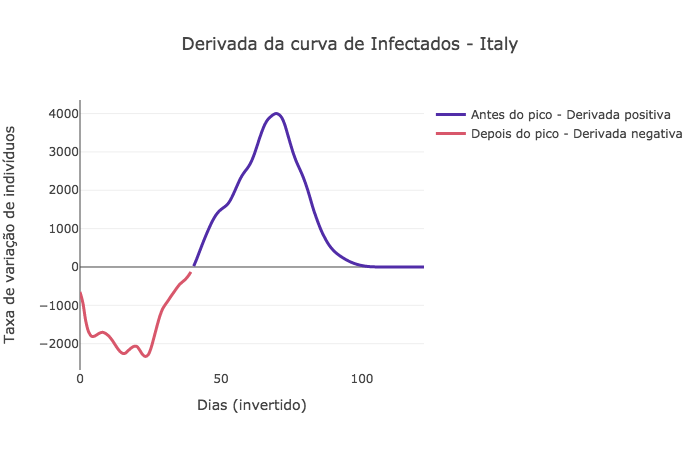

In [59]:

from PyAstronomy import pyasl

dI = np.gradient(pyasl.smooth(I, 13, "hamming"))
t = np.linspace(0, len(dI), len(dI))

signal = np.array([di >= 0 for di in dI[::-1]])


import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(
                    x=t[signal], 
                    y=dI[::-1][signal],
                    mode='lines',
                    name='Antes do pico - Derivada positiva',
                    line_shape='spline',
                    line = dict(color='#512da8', width=3)))
fig.add_trace(go.Scatter(
                    x=t[~signal], 
                    y=dI[::-1][~signal],
                    mode='lines',
                    line_shape='spline',
                    name='Depois do pico - Derivada negativa',
                    line = dict(color='#d8576b', width=3)))

fig.update_layout(template='xgridoff',
                  xaxis_title='Dias (invertido)',
                  yaxis_title='Taxa de variação de indivíduos',
                  title_text="Derivada da curva de Infectados - " + country['data']['name'])
# 'ggplot2', 'seaborn', 'simple_white', 'plotly',
# 'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
# 'ygridoff', 'gridon', 'none'

fig.show(renderer="png")


In [13]:

peak_pos = len(Id) - np.argmax(signal)
print("O pico da epidemia acontece no dia", peak_pos)

start_day = 35
final_day = int(td[-1])

estimated_peaks = []
for data in saved_prediction:
    dI = np.gradient(data[1][:final_day])
    signal_pred = np.array([di >= 0 for di in dI[::-1]])
    estimated_peaks.append(len(Id) - np.argmax(signal_pred))
estimated_peaks = np.array(estimated_peaks)


O pico da epidemia acontece no dia 81


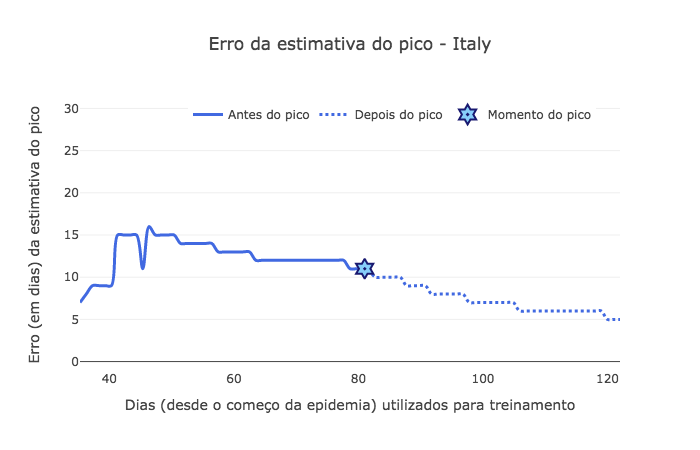

In [60]:

import plotly.graph_objects as go

peak_error = np.abs(estimated_peaks - peak_pos)

fig1 = go.Figure()
fig1.add_trace(go.Scatter(
                    x=td[start_day:peak_pos], 
                    y=peak_error[:peak_pos-start_day],
                    mode='lines',
                    name='Antes do pico',
                    line_shape='spline',
                    line = dict(color='royalblue', width=3),
                    hovertemplate="Erro de %{y} dias, <br> com %{x:.0f} dias de dados."))
fig1.add_trace(go.Scatter(
                    x=td[peak_pos:], 
                    y=peak_error[peak_pos-start_day:],
                    mode='lines',
                    line_shape='spline',
                    name='Depois do pico',
                    line = dict(color='royalblue', width=3, dash='dot'),
                    hovertemplate="Erro de %{y} dias, <br> com %{x:.0f} dias de dados."))
fig1.add_trace(go.Scatter(
                    mode="markers", x=[peak_pos], y=[peak_error[peak_pos-start_day]], 
                    marker_symbol="hexagram-dot", name="Momento do pico",
                    marker_line_color="midnightblue", marker_color="lightskyblue", 
                    marker_line_width=2, marker_size=15, 
                    hovertemplate="Pico no dia %{x} depois do começo da epidemia."))

fig1.update_layout(yaxis_range=[-1,31], template='xgridoff',
                  legend_orientation="h", legend=dict(x=0.20, y=1.0),
                  xaxis_title='Dias (desde o começo da epidemia) utilizados para treinamento',
                  yaxis_title='Erro (em dias) da estimativa do pico',
                  title_text="Erro da estimativa do pico - " + country['data']['name'])
# 'ggplot2', 'seaborn', 'simple_white', 'plotly',
# 'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
# 'ygridoff', 'gridon', 'none'

fig1.show(renderer="png")


In [51]:
fig1.write_html("./docs/media_content/peak_estimate_IT.html")